In [10]:
# The following is necessary to run the cells that follow. Run this cell once at the beginning, then not again.
%load_ext autoreload
# Changes made to .py files are reflected here
%autoreload 2       
# Reload all modules every time before executing the Python code typed.
import sys         # used for path appending
import matplotlib.pyplot as plt # used for plotting
sys.path.append("../../") # / directory
sys.path.append("../")  # /src/ directory
plt.rcParams["figure.figsize"] = [6, 3.5] #  Size of figures created from plots by default [12,7]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A gc_event_dataframe has the following columns
> ## DateTime

> ## TimeFromStart_seconds

> ## EventType

> ## EventName

> ## AdditionalEventInfo

> ## MemoryChange_MB

> ## Duration_miliseconds

In [23]:

                        # Fill in the following 3 variables
################################################################################################
files = ["/Users/ellisbrown/Desktop/Project/cassandra-data/apache1/logs/gc.log"]
labels = ["Shenandoah", "Example-transactions"]
# time_range_seconds = [0, 100]
time_range_seconds = None  # includes full log
################################################################################################
from src.read_log_file import get_parsed_comparions_from_files 

# Create a list data structure, with each item in the list being a gc_event_dataframe.
gc_event_dataframes = get_parsed_comparions_from_files(files, time_range_seconds,  ignore_crashes=False)


################################## OPTIONAl ############################################

# Import any CSV files that you would like.
csv_files_to_import = ["../../tutorials/tutorial-files/example_data.csv"] # Populate this with CSV files.
import os.path


################################################################################################

import pandas as pd
for csv_file in csv_files_to_import:
    if os.path.isfile(csv_file):
        gc_event_dataframes.append(pd.read_csv(csv_file))
    else:
        print("Error: Unable to find file " + csv_file)

## Compare STW pauses during runtime

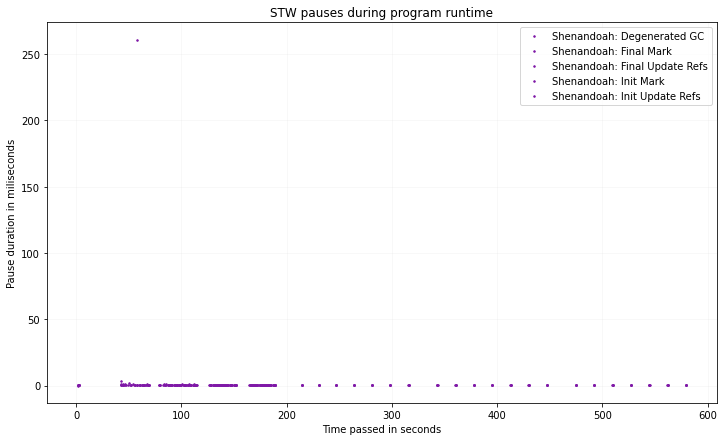

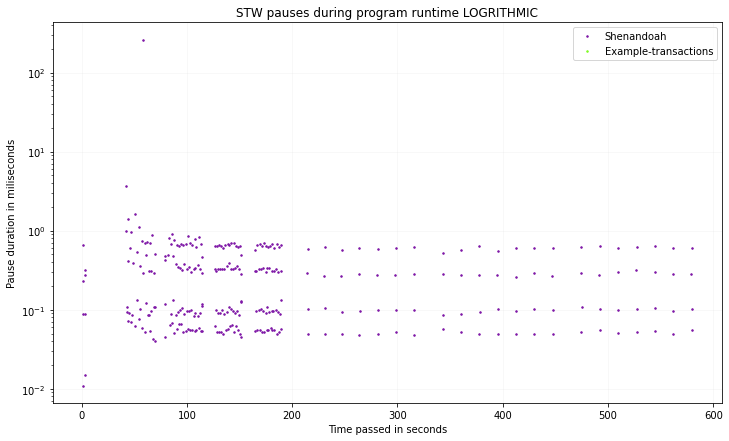

In [36]:
from plotting import plot_scatter

# Chart #1, linear Y axis

# Create a filter that will only take rows from a gc_event_dataframe that represent Pauses.
pauses_only = [(lambda row : row["EventType"] == "Pause")]

# Apply the filter, and create a plot
plot = plot_scatter(gc_event_dataframes,filter_by = pauses_only, labels=labels, group_by="EventName")

# Set the style and details on the plot
_ = plot.set_title("STW pauses during program runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
# The alpha value makes the grid harder to see.9
plot.grid(alpha = 0.1)

############################################################################################################

# Chart #2, logarithmic Y axis
plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels = labels)
plot.set_yscale("log") # LOGRITHMIC log set, using already plotted values
_ = plot.set_title("STW pauses during program runtime LOGRITHMIC")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
plot.grid(alpha = 0.1)



## Concurrent durations during runtime

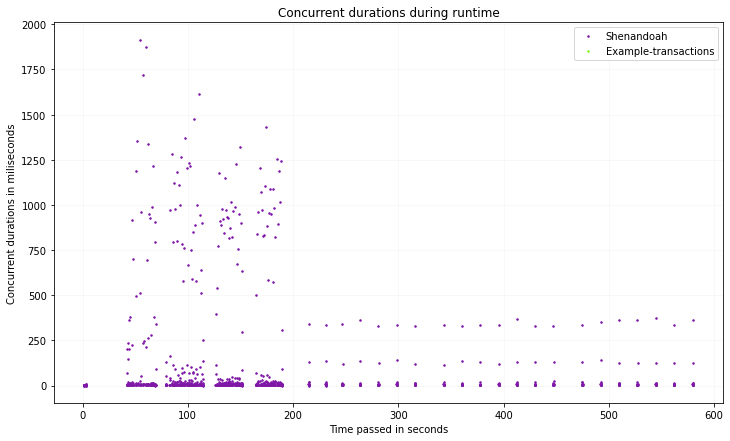

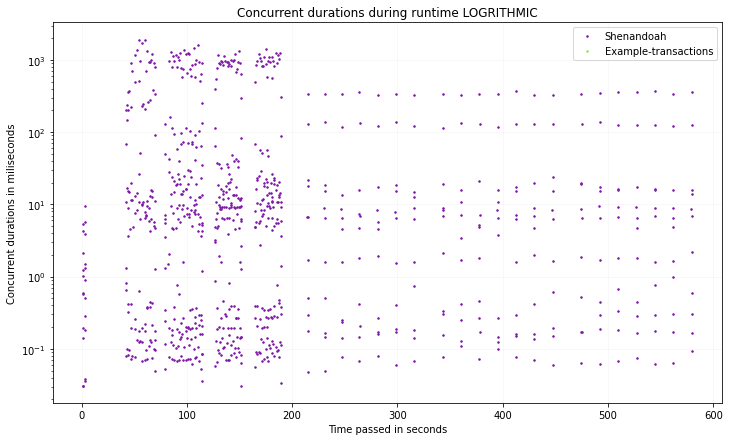

In [25]:
from plotting import plot_scatter

# Linear graph
concurrent_only = [(lambda row: row["EventType"] == "Concurrent")]
plot = plot_scatter(gc_event_dataframes, labels=labels, filter_by= concurrent_only)
_ = plot.set_title("Concurrent durations during runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Concurrent durations in miliseconds")
plot.grid(alpha = 0.1)

# Logarithmic graph
plot = plot_scatter(gc_event_dataframes, labels=labels, filter_by= concurrent_only)
plot.set_yscale("log")
_ = plot.set_title("Concurrent durations during runtime LOGRITHMIC")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Concurrent durations in miliseconds")
plot.grid(alpha = 0.1)


## Time spent in STW vs. Concurrent

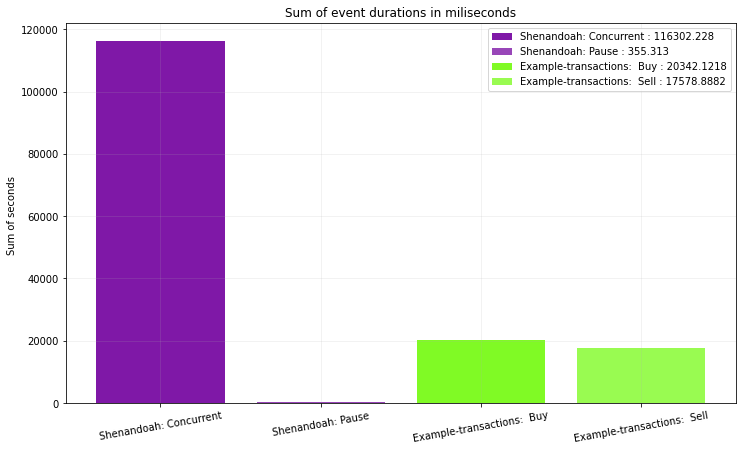

In [26]:
from plotting import plot_bar_sum

log = False # Set to True to view log bar graph as well

duration_present = [(lambda row: row["Duration_miliseconds"] != None)]
# The grouping by eventtype means that every matching event name lives in one group. 
# Example: "Concurrent" events are a group, and "Pause" events are a group
plot = plot_bar_sum(gc_event_dataframes, group_by = "EventType", filter_by = duration_present, labels= labels)
_ = plot.set_title("Sum of event durations in miliseconds")
_ = plot.set_ylabel("Sum of seconds ")
_ = plt.xticks(rotation = 10)
plot.grid(alpha = 0.2)
if log:
    plot = plot_bar_sum(gc_event_dataframes, group_by = "EventType", filter_by = duration_present, labels= labels)
    _ = plot.set_title("Sum of event durations in miliseconds, LOGARITHMIC")
    _ = plot.set_ylabel("Sum of seconds ")
    plot.set_yscale("log") # LOGRITHMIC log set, using already plotted values
    plot.grid(alpha = 0.2)
    _ = plt.xticks(rotation = 10)



## Comparing Trends within the data

In [27]:
from plotting import plot_trends

print("\t\t\tPauses during runtime\n------------------------------------------------------------------------------------------------------------------")
plot_trends(gc_event_dataframes, 
       filter_by = [lambda row: row["EventType"] == "Pause"],
       labels= labels,
       throughput=True)
print("\n")

print("\t\t\tPauses by name during runtime\n------------------------------------------------------------------------------------------------------------------")
plot_trends(gc_event_dataframes, 
       group_by = "EventName",
       filter_by= [lambda row: row["EventType"] == "Pause"],
       labels= labels)


			Pauses during runtime
------------------------------------------------------------------------------------------------------------------
Legend: 
A | Shenandoah
B | Example-transactions
-------------------------------------------------------------------------------------------------
  Trends (ms)   | Event Count   | Max Duration  | Sum Duration  | Mean Duration | Std Dev.      | Throughput    |
-----------------------------------------------------------------------------------------------------------------
A               |  312.0000     |  260.9410     |  355.3130     |    1.1388     |   14.7357     |   99.9400     % 
B               |    0.0000     |    0.0000     |    0.0000     |    0.0000     |    0.0000     | 


			Pauses by name during runtime
------------------------------------------------------------------------------------------------------------------
Legend: 
A | Shenandoah: Degenerated GC
B | Shenandoah: Final Mark
C | Shenandoah: Final Update Refs
D | Shenandoah: Init

## Percentiles of event durations

In [28]:
from plotting import plot_percentiles
print("\t\t\tPauses during runtime\n----------------------------------------------------------------------------------")
plot_percentiles(gc_event_dataframes, 
       filter_by = [lambda row: row["EventType"] == "Pause"],
       labels= labels)

print("\n\n")

print("\t\t\tPauses during runtime by name\n----------------------------------------------------------------------------------")
plot_percentiles(gc_event_dataframes, 
       group_by = "EventName",
       filter_by= [lambda row: row["EventType"] == "Pause"],
       labels= labels)

			Pauses during runtime
----------------------------------------------------------------------------------
Legend (All timing in miliseconds) : 
A | Shenandoah
B | Example-transactions
-------------------------------------------------------------------------------------------------
    | 50%       | 75%       | 90%       | 95%       | 99%       | 99.9%     | 99.99%    | 
------------------------------------------------------------------------------------------------
A   |    0.2470 |    0.5155 |    0.6580 |    0.7144 |    1.3563 |  180.9397 |  252.9409 | 



			Pauses during runtime by name
----------------------------------------------------------------------------------
Legend (All timing in miliseconds) : 
A | Shenandoah: Degenerated GC
B | Shenandoah: Final Mark
C | Shenandoah: Final Update Refs
D | Shenandoah: Init Mark
E | Shenandoah: Init Update Refs
-------------------------------------------------------------------------------------------------
    | 50%       | 75%       | 9

## Mean durations in miliseconds, pauses

['Shenandoah', 'Example-transactions']
['Shenandoah', 'Example-transactions']


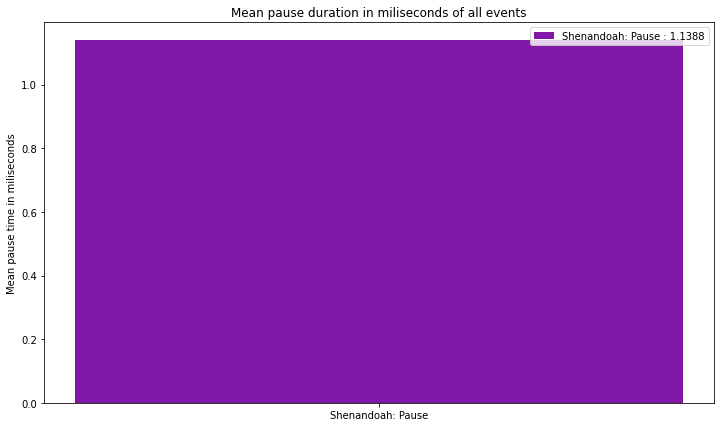

In [29]:

from plotting import plot_bar_avg
print(labels)
graph = plot_bar_avg(gc_event_dataframes, group_by = "EventType", filter_by = [lambda row: row["EventType"] == "Pause"], labels = labels)
_ = graph.set_title("Mean pause duration in miliseconds of all events")
_ = graph.set_ylabel("Mean pause time in miliseconds")
print(labels)

## Heap allocation used before & after GC

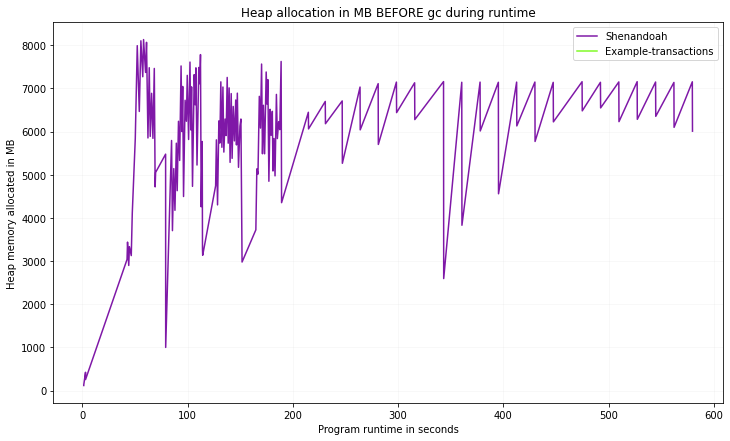

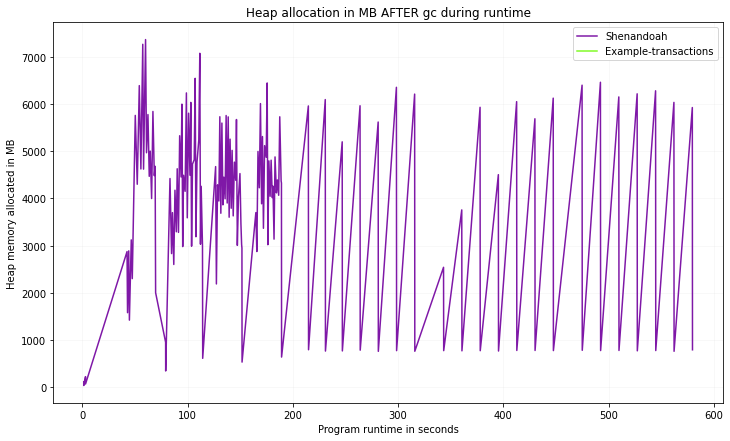

In [30]:
from plotting import plot_line


plot = plot_line(gc_event_dataframes,
            group_by = None, 
            filter_by = [lambda row: row["HeapBeforeGC"] != None], # Confirm that this column has data for every row
            labels = labels,
            column = "HeapBeforeGC")

_ = plot.set_title("Heap allocation in MB BEFORE gc during runtime")
_ = plot.set_ylabel("Heap memory allocated in MB")
_ = plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

plot = plot_line(gc_event_dataframes,
            group_by = None, 
            filter_by = [lambda row: row["HeapAfterGC"]!= None],
            labels = labels,
            column = "HeapAfterGC")

_ = plot.set_title("Heap allocation in MB AFTER gc during runtime")
_ = plot.set_ylabel("Heap memory allocated in MB")
_ = plot.set_xlabel("Program runtime in seconds")

handles, labels = plot.get_legend_handles_labels()
plot.grid(alpha = 0.1)

## MB reclaimed during GC during runtime

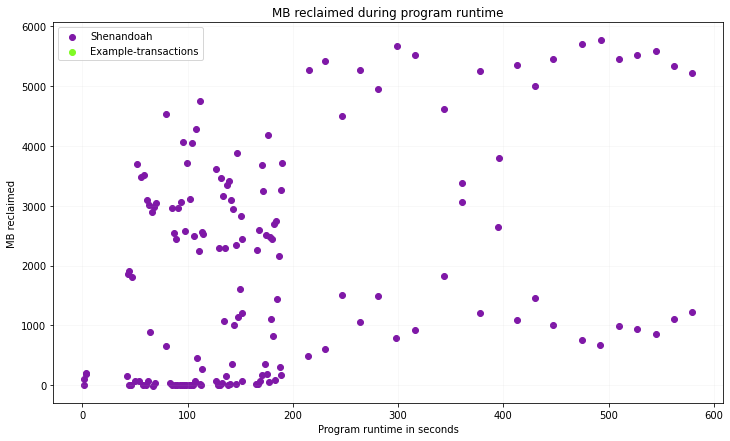

In [31]:
from plotting import plot_reclaimed_bytes

gc_values_present = [lambda row: row["HeapBeforeGC"] != None and row["HeapAfterGC"] != None]

plot = plot_reclaimed_bytes(gc_event_dataframes, filter_by = gc_values_present, labels = labels)
_ = plot.set_title("MB reclaimed during program runtime")
_ = plot.set_ylabel("MB reclaimed")
_ = plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

## Heatmaps for each log

Shenandoah Warning: At least one value lies outside of the provided time range. Max value outside range: 579.695
Shenandoah Warning: At least one value lies outside the provided range for latency. Max value outside range: 1915.49
Example-transactions Warning: At least one value lies outside of the provided time range. Max value outside range: 233.278
Example-transactions Warning: At least one value lies outside the provided range for latency. Max value outside range: 304.917065


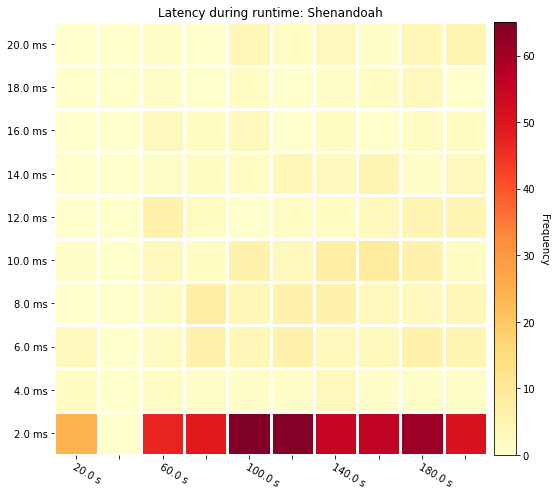

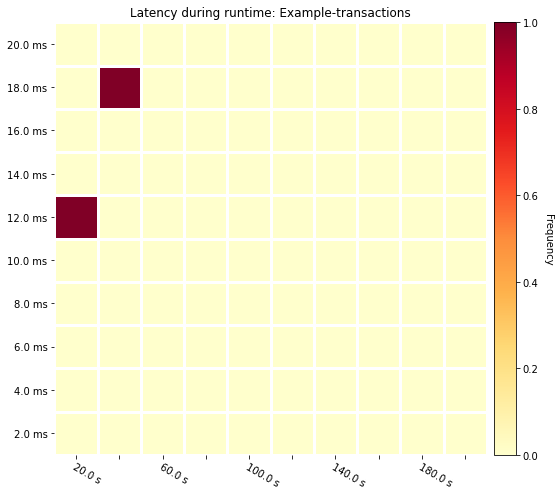

In [32]:
from src.graphing.heatmap import plot_heatmap, get_heatmap_data

for label, gc_event_dataframe in zip(labels, gc_event_dataframes):
    heatmap, dimensions = get_heatmap_data(gc_event_dataframe, 10,10, 20,2, label, True)     # Set the last value to FALSE to get warnings                                                                              # Set true to false 

#plot_heatmap(heatmap, dimensions, True)
    graph = plot_heatmap(heatmap, dimensions, False) # Set the last value to TRUE to see labels of frequency
    graph.set_title("Latency during runtime: " +  label)
plt.rcParams["figure.figsize"] = [12, 7]


## Frequency of pauses histogram

['Shenandoah', 'Example-transactions']


ValueError: cannot convert float NaN to integer

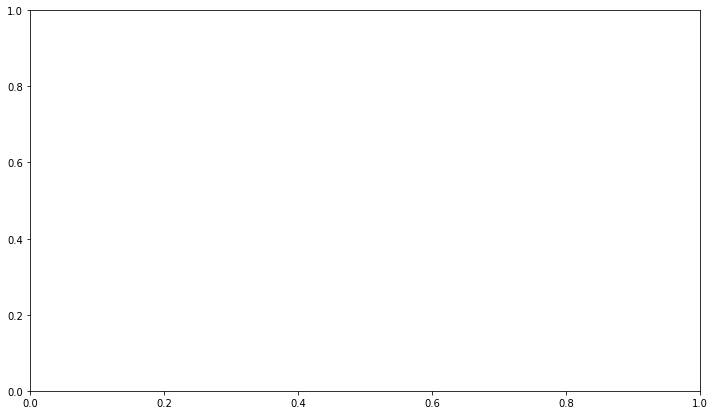

In [33]:
from plotting2 import plot_frequency_intervals

# All intervals are in seconds
print(labels)
plot = plot_frequency_intervals(gc_event_dataframes,
# /src
                         filter_by = [(lambda row: row["EventType"] == "Pause"), (lambda row: row["Duration_miliseconds"] < 100)], 
                         interval_duration= 10, 
                         labels = labels)
_ = plt.xticks(rotation = 20)
plot.set_xlabel("Pauses time interval in seconds")
plot.set_ylabel("Frequency")
plot.set_title("Pause frequencies during full runtime")


Percentiles plotted:  [99.9, 90, 50]


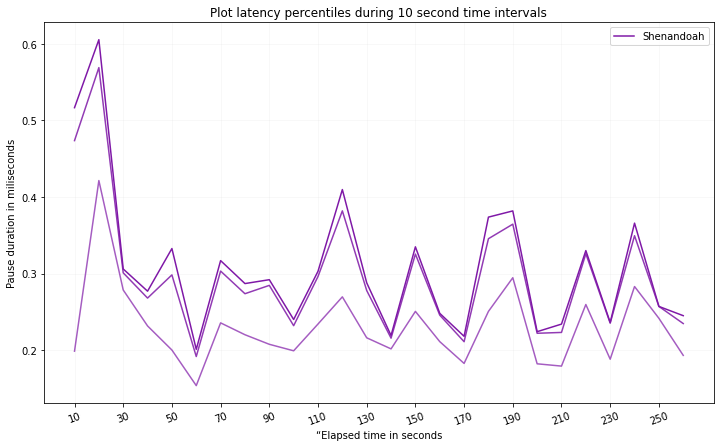

In [ ]:
from plotting2 import plot_percentile_intervals
interval_duration = 10
percentiles = [99.9, 90, 50]
plot = plot_percentile_intervals(gc_event_dataframes, 
                                filter_by = [(lambda row: row["EventType"] == "Pause")], 
                                interval_duration = interval_duration ,
                                labels = labels,
                                percentiles = percentiles )
plot.set_ylabel("Pause duration in miliseconds")
plot.set_xlabel("“Elapsed time in seconds")
plot.set_title("Plot latency percentiles during "+ str(interval_duration) + " second time intervals")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)
print("Percentiles plotted: ", percentiles)

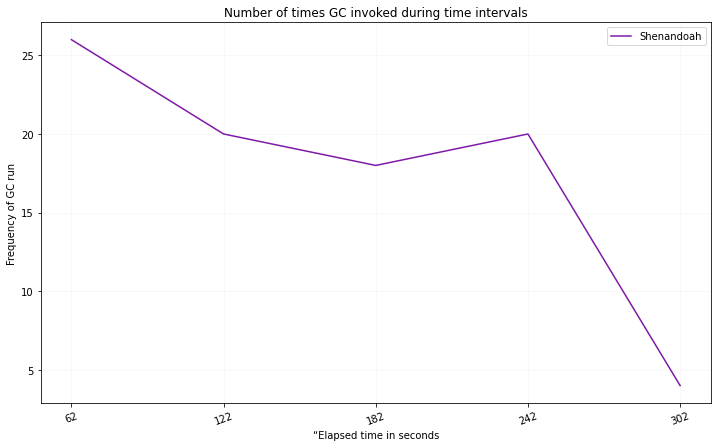

In [ ]:
from plotting2 import plot_frequency_of_gc_intervals

plot = plot_frequency_of_gc_intervals(gc_event_dataframes, 
                                      filter_by = [(lambda row: row["EventType"] == "Pause")], 
                                      interval_duration = 60 , 
                                      labels = labels)
plot.set_ylabel("Frequency of GC run")
plot.set_xlabel("“Elapsed time in seconds")
plot.set_title("Number of times GC invoked during time intervals")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)

1      0.495
3      0.517
10     0.031
13      0.09
16     0.192
       ...  
330    0.257
336    0.189
338    0.257
344    0.141
346    0.245
Name: Duration_miliseconds, Length: 88, dtype: object


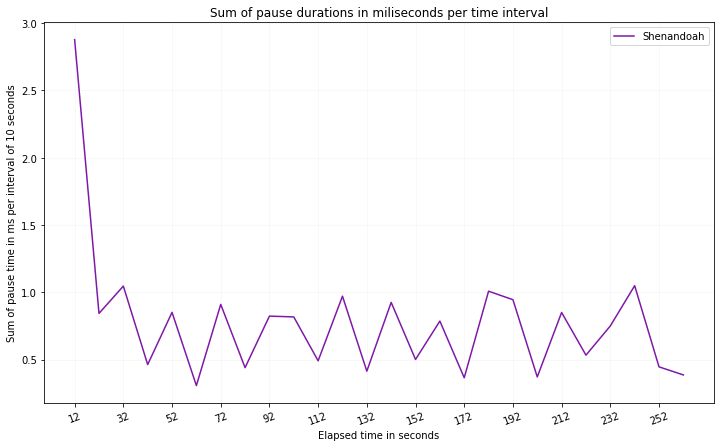

In [ ]:
from plotting2 import plot_sum_pause_intervals


interval_duration = 10
plot = plot_sum_pause_intervals(gc_event_dataframes,
                                filter_by = [(lambda row: row["EventType"] == "Pause")],
                                interval_duration = interval_duration, 
                                labels = labels)
_ = plot.set_title("Sum of pause durations in miliseconds per time interval")
plot.set_ylabel("Sum of pause time in ms per interval of " + str(interval_duration) + " seconds", )
plot.set_xlabel("Elapsed time in seconds")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)